In [55]:
from aimapp.visualisation_tools import plot_likelihood, pickle_load_model, plot_state_in_map
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns
from matplotlib import colors
from aimapp.obs_transf.observation_match import ViewMemory
from aimapp.model.V5 import Ours_V5_RW
from aimapp.model.odometry import PoseOdometry
from aimapp.model.modules import *
import matplotlib
# matplotlib.use('TkAgg')
%matplotlib inline

## plot visualisation

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_transitions(B: np.ndarray, state_map: dict, actions: dict) -> np.ndarray:
    """Plot Transitions matrix showing the probability of a transition between two states given a certain action."""
    
    sorted_state_map = dict(sorted(state_map.items(), key=lambda item: item[1]['state']))
    labels = [f"{key} ({value['state']})" for key, value in sorted_state_map.items()]

    n_actions = len(actions)
    l = int(np.ceil(np.sqrt(n_actions)))
    L = int(np.ceil(n_actions / l))
    
    fig, axes = plt.subplots(L, l, figsize=(L*3 + max(10, 2.5*len(state_map)), 
                                             l*2 + max(10, 1.5*len(state_map))))
    
    axes = np.atleast_2d(axes)  # Ensure axes is always a 2D array
    count = 0

    for i in range(L):
        for j in range(l):
            if count >= n_actions:
                fig.delaxes(axes[i][j])
                continue
            
            if count not in actions:
                continue

            action_str = str(actions[count])  # Convert action name to string

            # Plot the heatmap
            g = sns.heatmap(B[:len(labels), :len(labels), count], cmap="OrRd", linewidth=3, 
                            cbar=False, ax=axes[i, j], xticklabels=labels, yticklabels=labels)

            g.tick_params(axis='both', which='major', labelsize=14)  # Adjust label font size
            g.set_title(action_str, fontsize=20)
            g.set_xlabel('Prev State', fontsize=16)
            g.set_ylabel('Next State', fontsize=16)

            # Rotate labels for better visibility
            g.set_xticklabels(labels, rotation=45, ha="right", fontsize=12)
            g.set_yticklabels(labels, rotation=0, fontsize=12)
            
            count += 1

    plt.subplots_adjust(left=0.2, bottom=0.2)  # Add margin space
    plt.tight_layout()

    return fig


In [5]:
def compare_B1_B2_plots(B1: np.ndarray, B2: np.ndarray, state_map: dict, actions: dict) -> np.ndarray:
    """Plot Transitions matrix showing the probability of a transition between two states given a certain action.
       Common values in B1 and B2 (within a margin of 0.1) are set to 0 in the resulting B.
    """
    
    # Create B by zeroing out common values within margin 0.1
    margin = 0.1
    B = np.where(np.abs(B1 - B2) <= margin,0, B2)
    
    sorted_state_map = dict(sorted(state_map.items(), key=lambda item: item[1]['state']))
    labels = [f"{key} ({value['state']})" for key, value in sorted_state_map.items()]

    n_actions = len(actions)
    l = int(np.ceil(np.sqrt(n_actions)))
    L = int(np.ceil(n_actions / l))
    
    fig, axes = plt.subplots(L, l, figsize=(L*3 + max(10, 2.5*len(state_map)), 
                                             l*2 + max(10, 1.5*len(state_map))))
    
    axes = np.atleast_2d(axes)  # Ensure axes is always a 2D array
    count = 0

    for i in range(L):
        for j in range(l):
            if count >= n_actions:
                fig.delaxes(axes[i][j])
                continue
            
            if count not in actions:
                continue

            action_str = str(actions[count])  # Convert action name to string

            # Plot the heatmap
            g = sns.heatmap(B[:len(labels), :len(labels), count], cmap="OrRd", linewidth=3, 
                            cbar=False, ax=axes[i, j], xticklabels=labels, yticklabels=labels)

            g.tick_params(axis='both', which='major', labelsize=14)  # Adjust label font size
            g.set_title(action_str, fontsize=20)
            g.set_xlabel('Prev State', fontsize=16)
            g.set_ylabel('Next State', fontsize=16)

            # Rotate labels for better visibility
            g.set_xticklabels(labels, rotation=45, ha="right", fontsize=12)
            g.set_yticklabels(labels, rotation=0, fontsize=12)
            
            count += 1

    plt.subplots_adjust(left=0.2, bottom=0.2)  # Add margin space
    plt.tight_layout()

    return fig, B

# Model

In [210]:
model_dir = '/home/idlab332/workspace/ros_ws/tests/7/step_1'

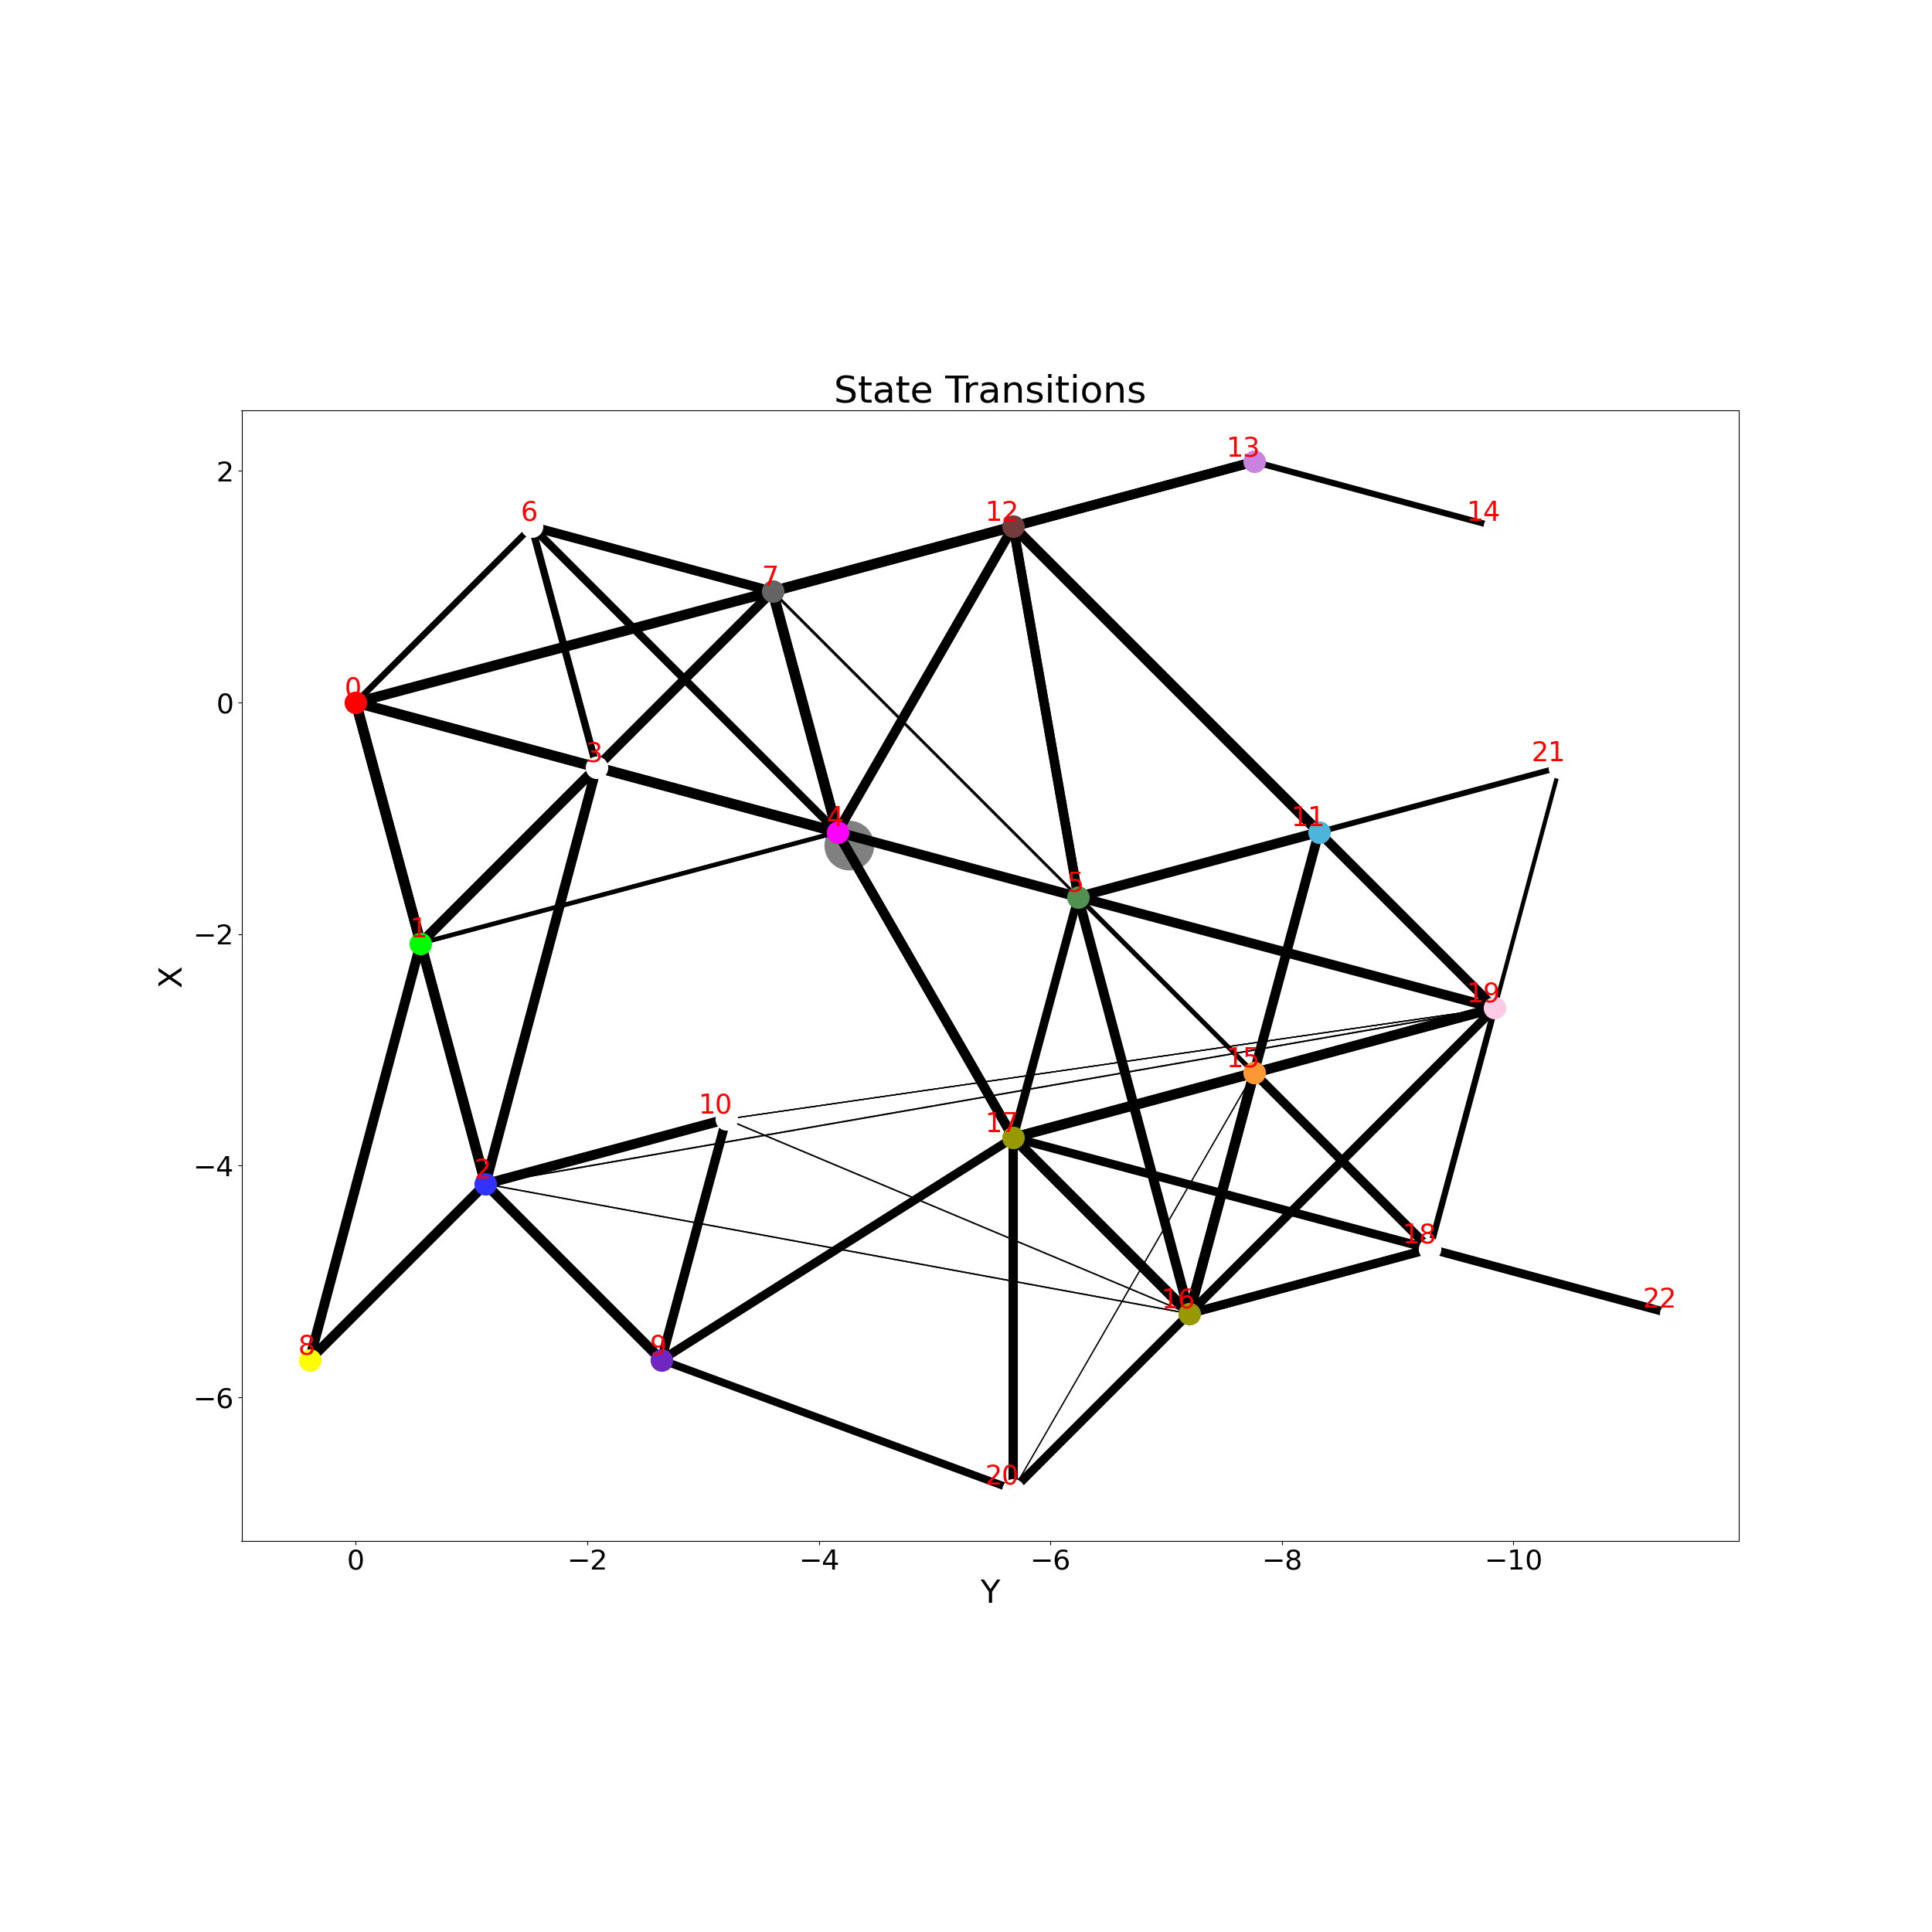

In [7]:
ob_id = -1
pose_id = -1

In [211]:
Views = ViewMemory(matching_threshold=0.7)

#load model
model = pickle_load_model(model_dir)
Views.set_memory_views(model.get_memory_views())
#self.model.policy_len = 5

#Didn't exist during exploration runs (they were fixed parameters, not self)
model.num_simulations = 30  # Number of MCTS simulations per planning step
model.max_rollout_depth = 10 # Maximum depth for the simulation (rollout) phase
model.c_param = 5

#We changed some methods so, we need to consider them
pose_memory = PoseOdometry(model.possible_actions, model.influence_radius, model.robot_dim)
pose_memory.odometry = model.PoseMemory.odometry
pose_memory.poses = model.PoseMemory.poses 


In [212]:
model.B[0].shape[0]

39

### PLot Model before change

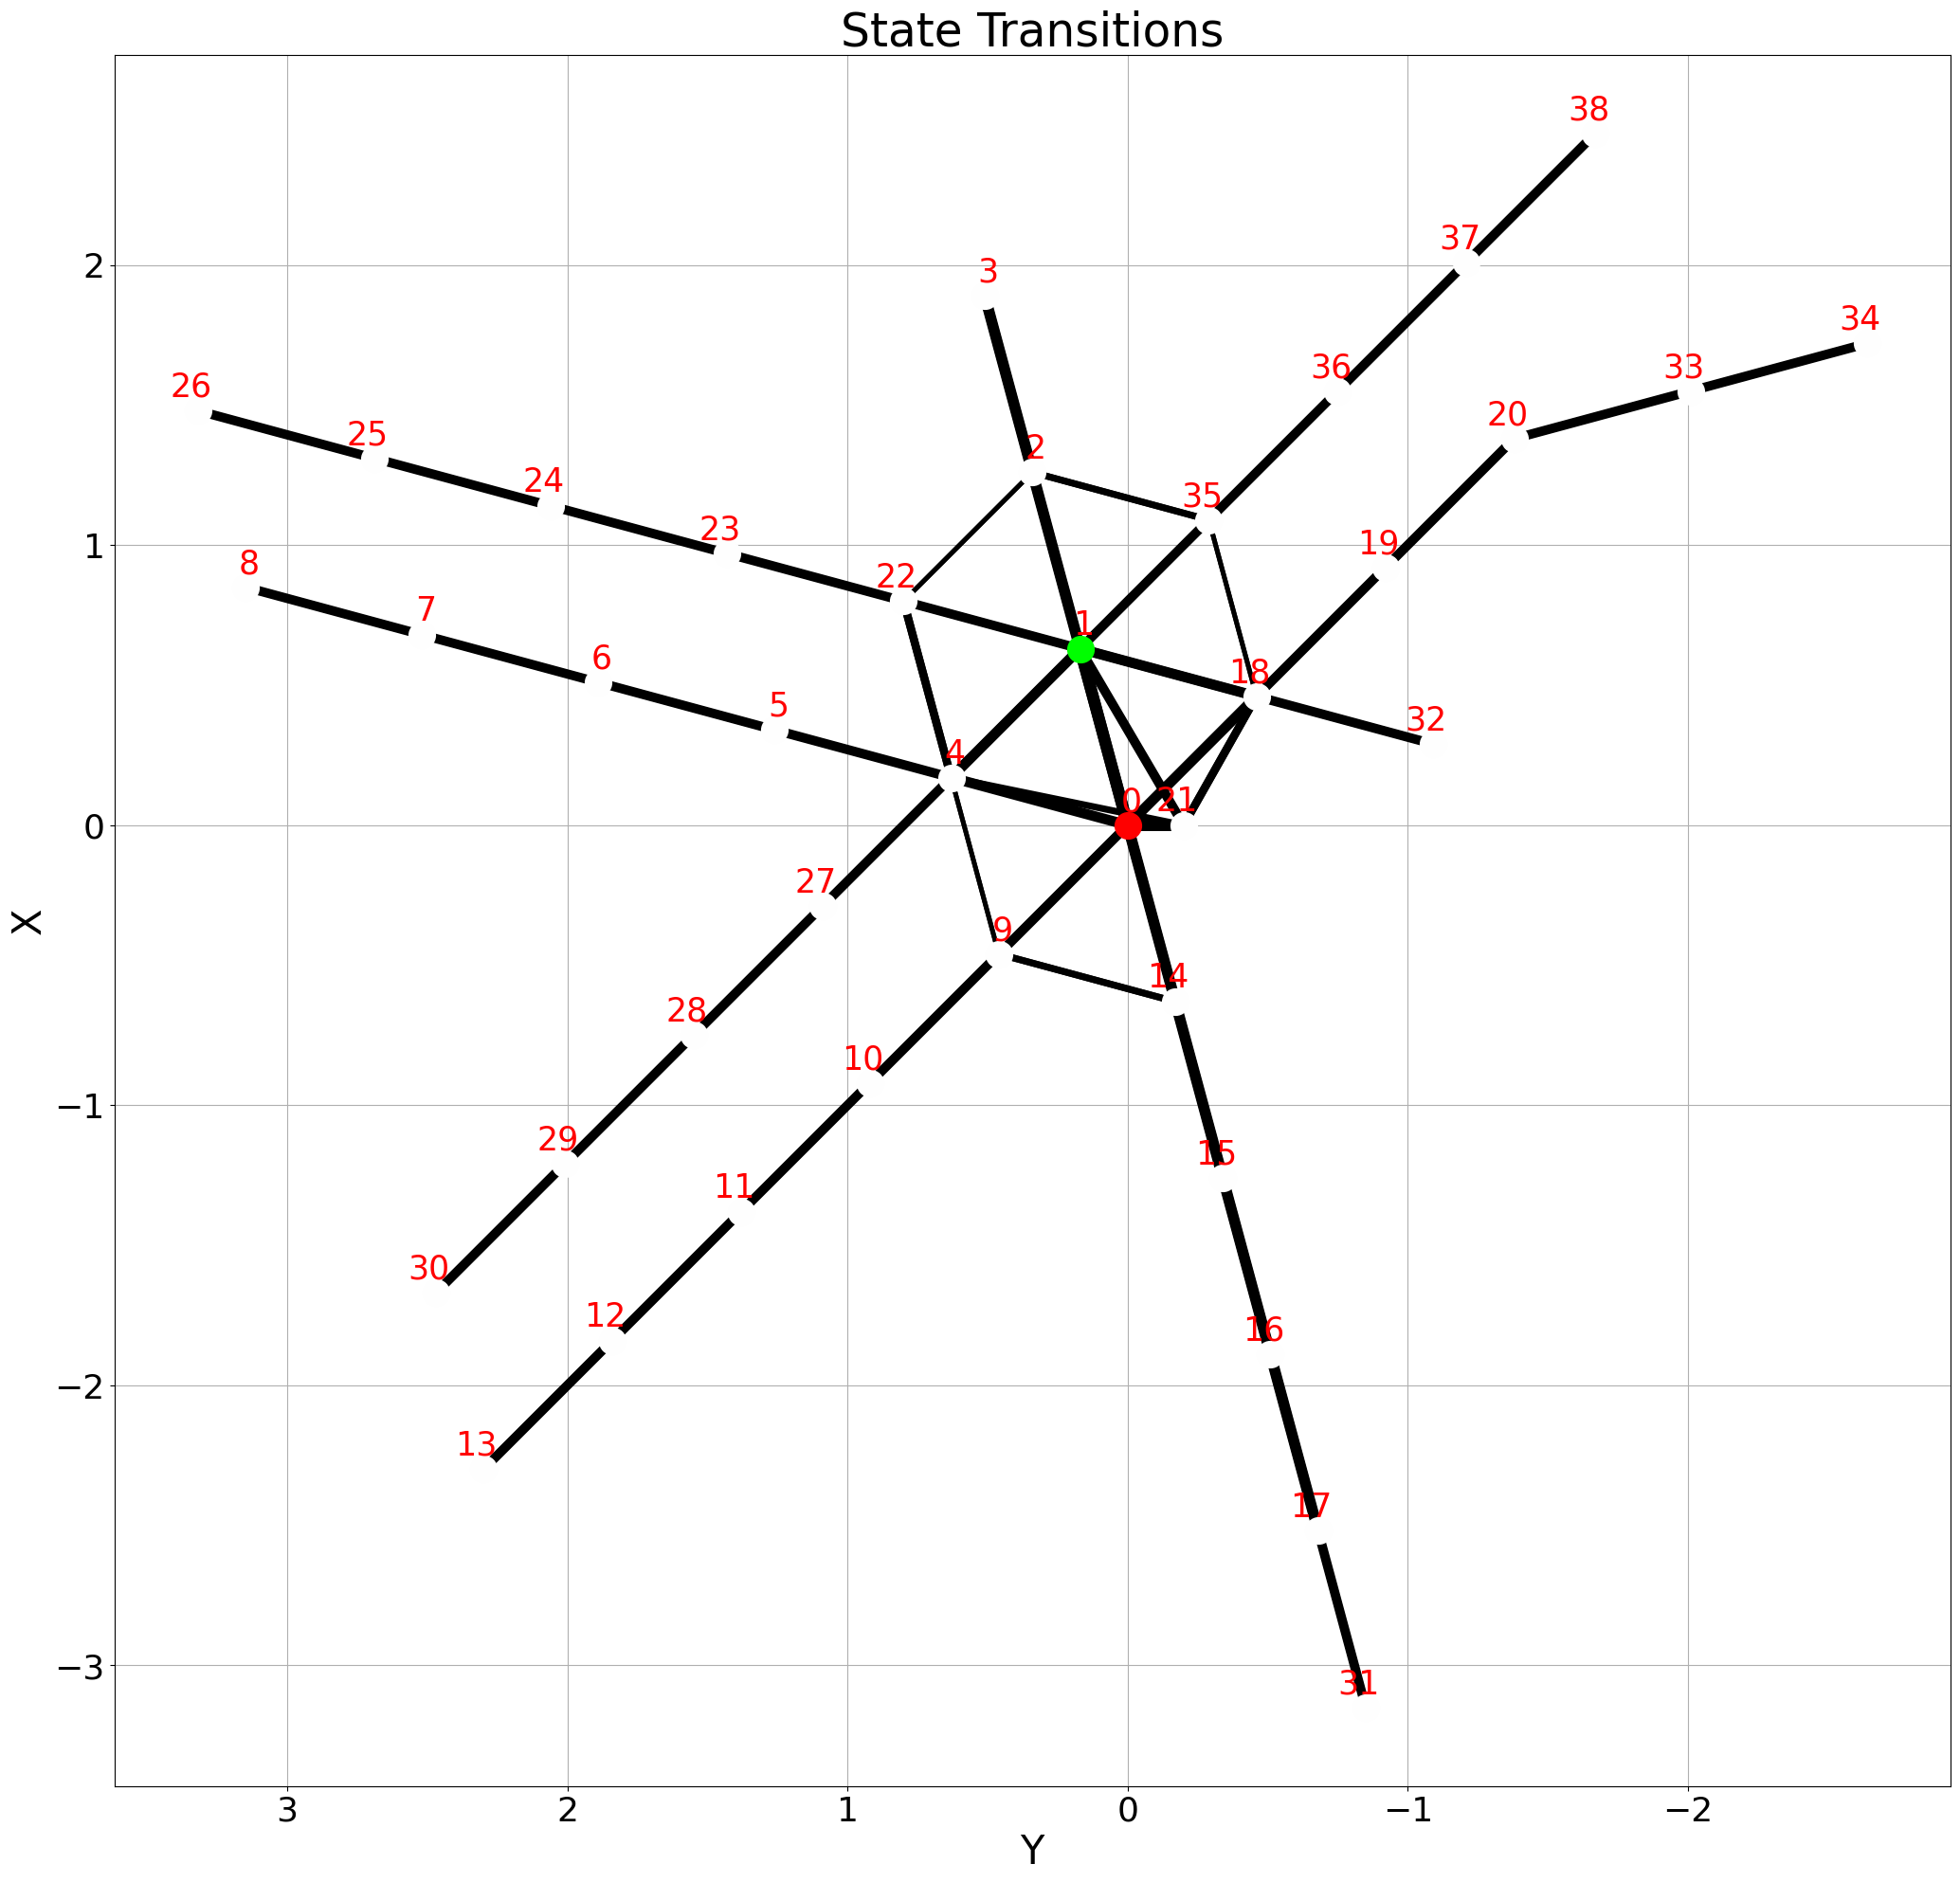

In [213]:
fig = plot_state_in_map(model.get_B(), model.get_agent_state_mapping())
plt.grid('True')
fig.canvas.draw()


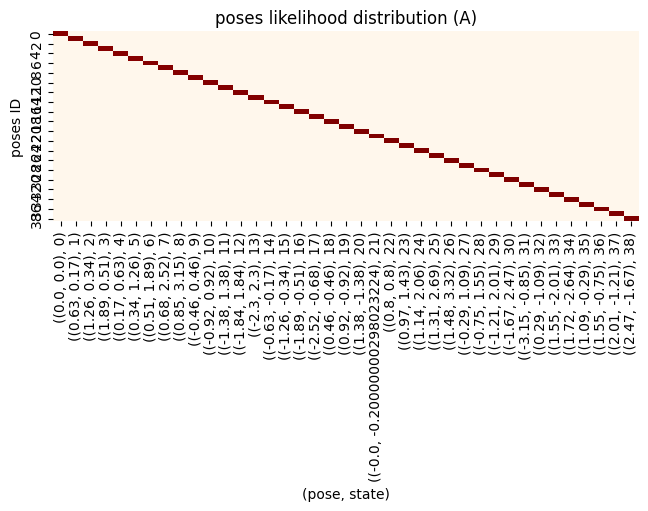

In [214]:
A = plot_likelihood(model.get_A()[1], model.get_agent_state_mapping(), \
                        'poses')

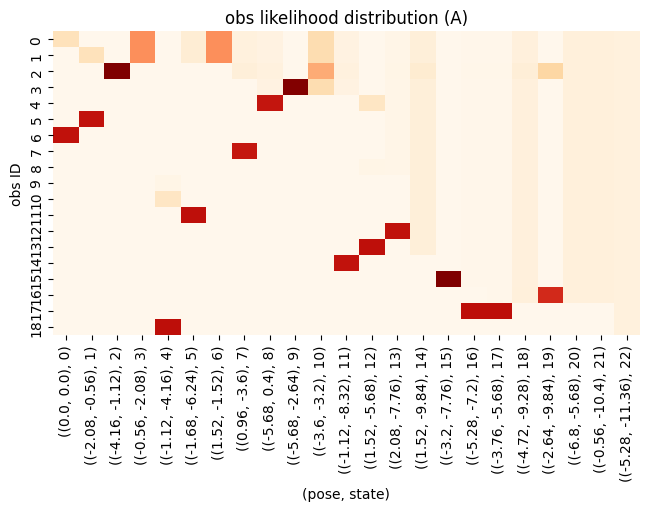

In [203]:
A = plot_likelihood(model.get_A()[0], model.get_agent_state_mapping(), \
                        'obs')

In [215]:
B = plot_transitions(model.get_B(), model.get_agent_state_mapping(), model.possible_actions)

## add a new node at position X

In [208]:
def inject_new_node_given_pose_and_linked_states(self, new_pose,junction_states, influence_radius=0.1):
    '''
    Inserts a new node (pose and corresponding state) into the model and updates
    transitions with the provided linked (junction) states (and no others).

    This method is used to expand the model's internal graph of poses and states:
    - A new pose is registered in PoseMemory (even if nearby poses exist, unless
      within given `influence_radius`).
    - The model dimensions (A, B, C, qs) are updated to account for the new state.
    - A new state belief distribution (qs) is created for the new pose.
    - The mapping between the agent's pose and its corresponding state(s) is updated.
    - Transitions are added both ways between the new state and the provided
      `junction_states`, based on geometric relations (angles, actions).
    - Existing self-transitions for linked states are reduced in probability
      to encourage movement towards the new state.

    Args:
        new_pose (tuple, list or np.ndarray): The (x, y) position of the new pose to inject.
        junction_states (list[int]): List of state indices to which the new state should be connected.
        influence_radius (float, optional): Minimum distance threshold (in meters)
            below which an existing pose is reused instead of creating a new one.
            Default is 0.1m.
    '''

    num_of_states = self.num_states[0]
    #We want this new pose to be added, even if there are other poses in the model influence_radius. Basically if there are no poses at 10cm distance, we will create a new one.
    new_pose_id = self.PoseMemory.pose_to_id(new_pose, odom = new_pose, save_in_memory=True, influence_radius=influence_radius)

    
    print('new_pose_id', new_pose_id)
    #Make sure the model can accept a new state (nothing happens for known pose)
    self.update_A_dim_given_pose(new_pose_id)
    self.update_B_dim_given_A()
    self.update_C_dim()
    self.update_qs_dim()
    print('num of states', num_of_states, 'new num of states', self.num_states[0])
    if num_of_states == self.num_states[0]:
        print('There are no new node to add, so we are done here')
        return
    #update transitions between states
    new_state_id = self.get_observation_most_likely_states(observations=[-1,new_pose_id], per_threshold=0.85)
    new_state_qs = np.zeros(self.num_states)
    for state in new_state_id:
        new_state_qs[state] = 1.0
    print('new state qs', new_state_qs)
    self.update_agent_state_mapping(tuple(new_pose), [-1, new_pose_id], new_state_qs)
    ## UPDATE TRANSITIONS
    for state in junction_states:
        state_qs = np.zeros(self.num_states)
        state_qs[state] = 1.0
        p_idx = -1
        z_score = 5
        #Cleaner way as it does not assume pose_id and state_id are the same
        while p_idx == -1 and z_score >=0.5:
            p_idx = self.get_current_most_likely_pose(z_score=z_score, qs=state_qs)
            z_score -= 0.5
        #If no correspondance found, we rely on pose_id == state_id as a failsafe
        if p_idx == -1 :
            p_idx = state
        state_pose = self.PoseMemory.id_to_pose(p_idx)
        print(p_idx,state_pose)
        angle = angle_turn_from_pose_to_p(pose = state_pose, goal_pose= new_pose, in_deg=True)
        action = self.determine_action_given_angle_deg(angle)
        #check all correct
        pose_in_action_range = self.PoseMemory.pose_in_action_range(action, new_pose, odom= state_pose)
        print('angle',angle, ' action', action,'pose_in_action_range', pose_in_action_range)
        direct_lr_pB = 10
        reverse_lr_pB = 10
        self.update_transitions_both_ways([state_qs], [new_state_qs], action, direct_lr_pB=direct_lr_pB, reverse_lr_pB=reverse_lr_pB)
        #reduce proba of going toward same state in that direction (if there was an obstacle at standard influence radius)
        self.update_transitions_both_ways([state_qs], [state_qs], action, direct_lr_pB=-30, reverse_lr_pB=-30)
        if 'STAY' in self.possible_actions.values():
            stay_action = [key for key, value in self.possible_actions.items() if value == 'STAY'][0]
            self.B[0] = set_stationary(self.B[0], stay_action)

    return self




In [209]:
junction_state = [4]
new_pose = (-2,-5)
model = inject_new_node_given_pose_and_linked_states(model,  new_pose=new_pose, junction_states=junction_state,influence_radius=0.1)

new_pose_id 23
num of states 24 new num of states 24
There are no new node to add, so we are done here


In [ ]:
# junction_states = [4]
# new_pose= (-2, -4) 
# for state in junction_states:
#    state_qs = np.zeros(model.num_states)
#    state_qs[state] = 1.0
#    p_idx = -1
#    z_score = 5
#    #Cleaner way as it does not assume pose_id and state_id are the same
#    while p_idx == -1 and z_score >=0.5:
#       p_idx = model.get_current_most_likely_pose(z_score=z_score, qs=state_qs)
#       z_score -= 0.5
#    print(p_idx)
#    #If no correspondance found, we rely on pose_id == state_id as a failsafe
#    if p_idx == -1 :
#       p_idx = state
#    state_pose = model.PoseMemory.id_to_pose(p_idx)
#    print(p_idx,state_pose)
#    angle = angle_turn_from_pose_to_p(pose = state_pose, goal_pose= new_pose, in_deg=True)
#    action = model.determine_action_given_angle_deg(angle)
#    print('angle',angle, ' action', action)
#    #check all correct
#    pose_in_action_range = model.PoseMemory.pose_in_action_range(action, new_pose, odom= state_pose)
#    print('pose_in_action_range', pose_in_action_range)

#    model.update_transitions_both_ways(state_qs, adjacent_qs, action, direct_lr_pB=direct_lr_pB, reverse_lr_pB=reverse_lr_pB)
   # action = self.determine_action_given_angle_deg(angle)

4
4 (-1.12, -4.16)
angle 169.69515353123396  action 5
True


first inject node, then check what happens if created node in between two existing nodes

## Check what happens from new node

In [191]:
action = 7
ob_id = 19
obstacle_dist_per_actions = [3, 3,0.5,0.5,0.5,0.5,3,3,3,3,3,3]
model.action = np.array([7])
model.step_time()
model.infer_pose(new_pose)
model.agent_step_update(action,[ob_id, obstacle_dist_per_actions])

AttributeError: 'NoneType' object has no attribute 'action'

# check plots after

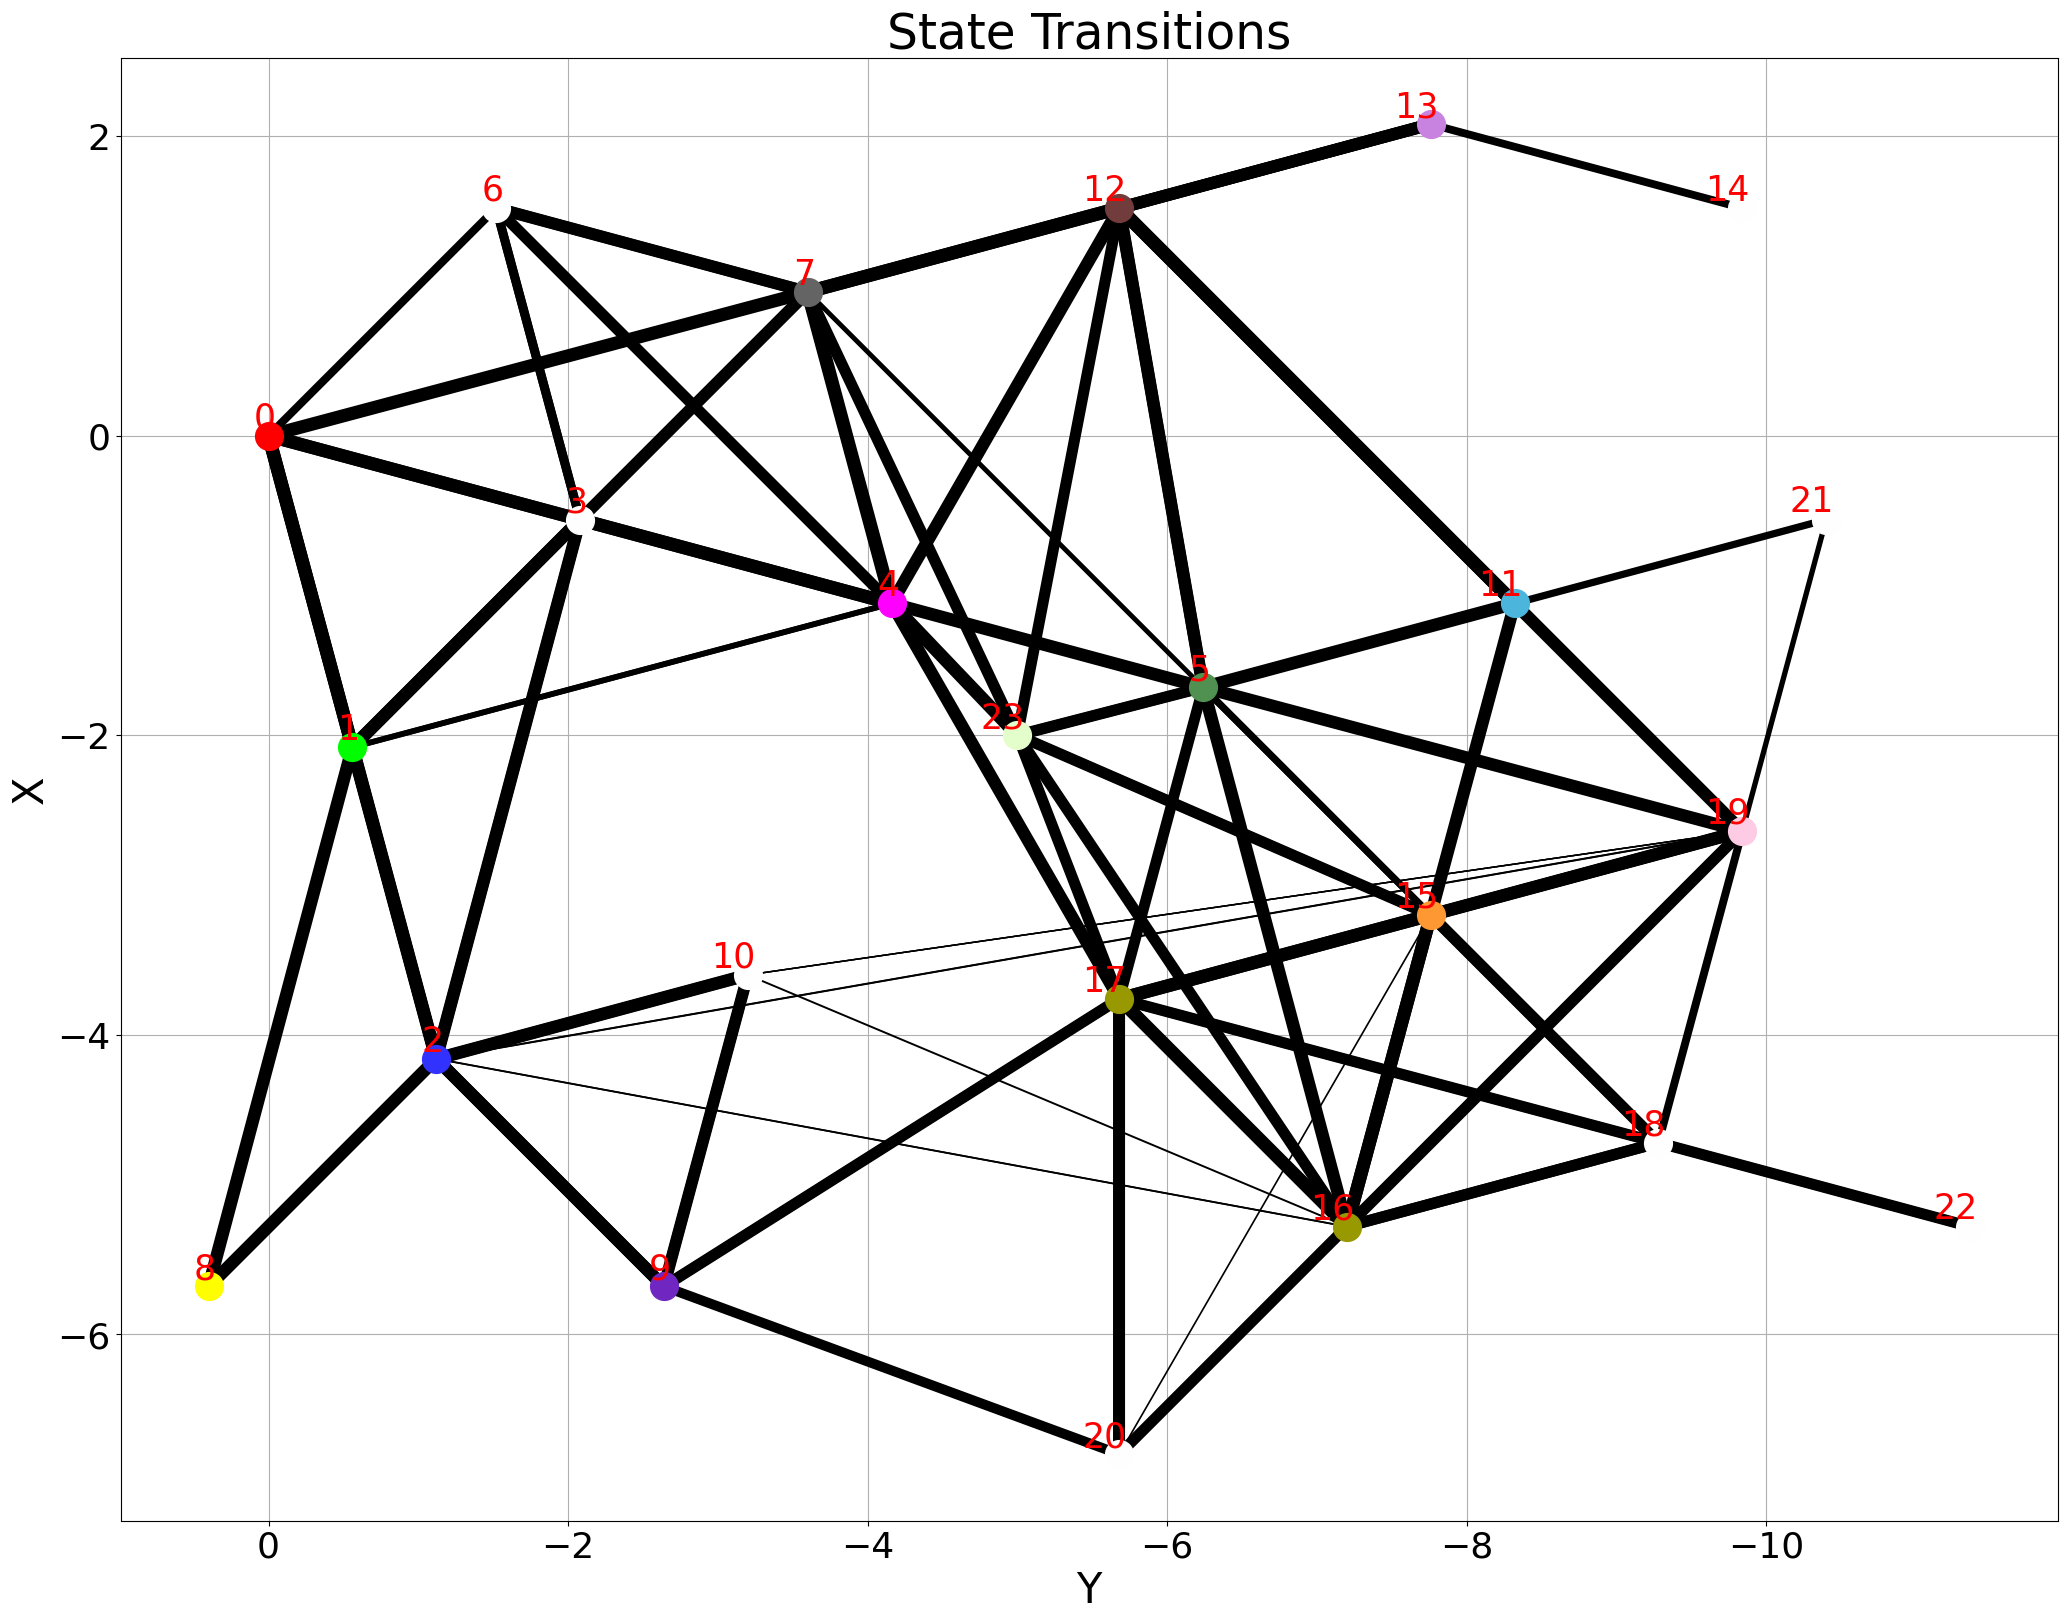

In [174]:
fig = plot_state_in_map(model.get_B(), model.get_agent_state_mapping())
plt.grid('True')
fig.canvas.draw()

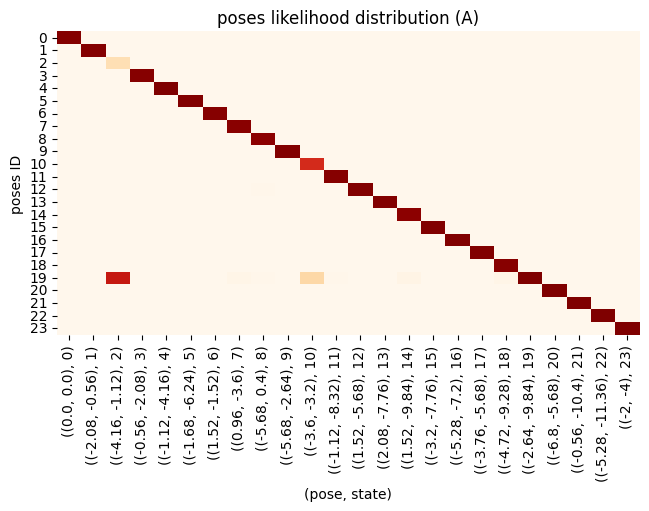

In [79]:
A = plot_likelihood(model.get_A()[1], model.get_agent_state_mapping(), \
                        'poses')

In [175]:
print(model.get_B()[23,:,7].round(3))
print(model.get_B()[:,23,1].round(3))

print()
print(model.get_B()[:,4,7].round(3))
print(model.get_B()[4,:,1].round(3))

[0.004 0.004 0.004 0.042 0.56  0.002 0.013 0.003 0.004 0.004 0.039 0.003
 0.002 0.042 0.042 0.008 0.004 0.002 0.042 0.003 0.042 0.042 0.042 0.008]
[0.002 0.002 0.002 0.002 0.95  0.002 0.002 0.002 0.002 0.002 0.002 0.002
 0.002 0.002 0.002 0.002 0.002 0.002 0.002 0.002 0.002 0.002 0.002 0.002]

[0.002 0.001 0.001 0.003 0.    0.242 0.001 0.001 0.001 0.001 0.001 0.001
 0.001 0.001 0.001 0.001 0.002 0.171 0.001 0.001 0.001 0.001 0.001 0.56 ]
[0.003 0.002 0.002 0.08  0.001 0.29  0.042 0.004 0.004 0.005 0.041 0.002
 0.002 0.004 0.042 0.002 0.003 0.896 0.01  0.005 0.042 0.042 0.042 0.95 ]


In [ ]:
junction_states = [4]
state_qs = np.zeros(model.num_states)
state_qs[junction_states[0]] = 1.0
next_qs = model.get_next_state_given_action(qs=[state_qs], action=7)[0]
state_qs
pose = model.PoseMemory.id_to_pose(junction_states[0])
pose_goal, next_pose_id = model.determine_next_pose(action_id=7,pose=pose)
pose_goal = model.PoseMemory.id_to_pose(next_pose_id)
print(pose_goal, next_pose_id)

(-2, -5) 23


In [161]:
next_qs[0].round(3)

array([0.002, 0.002, 0.002, 0.004, 0.   , 0.353, 0.002, 0.002, 0.002,
       0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.25 ,
       0.002, 0.002, 0.002, 0.002, 0.002, 0.358])

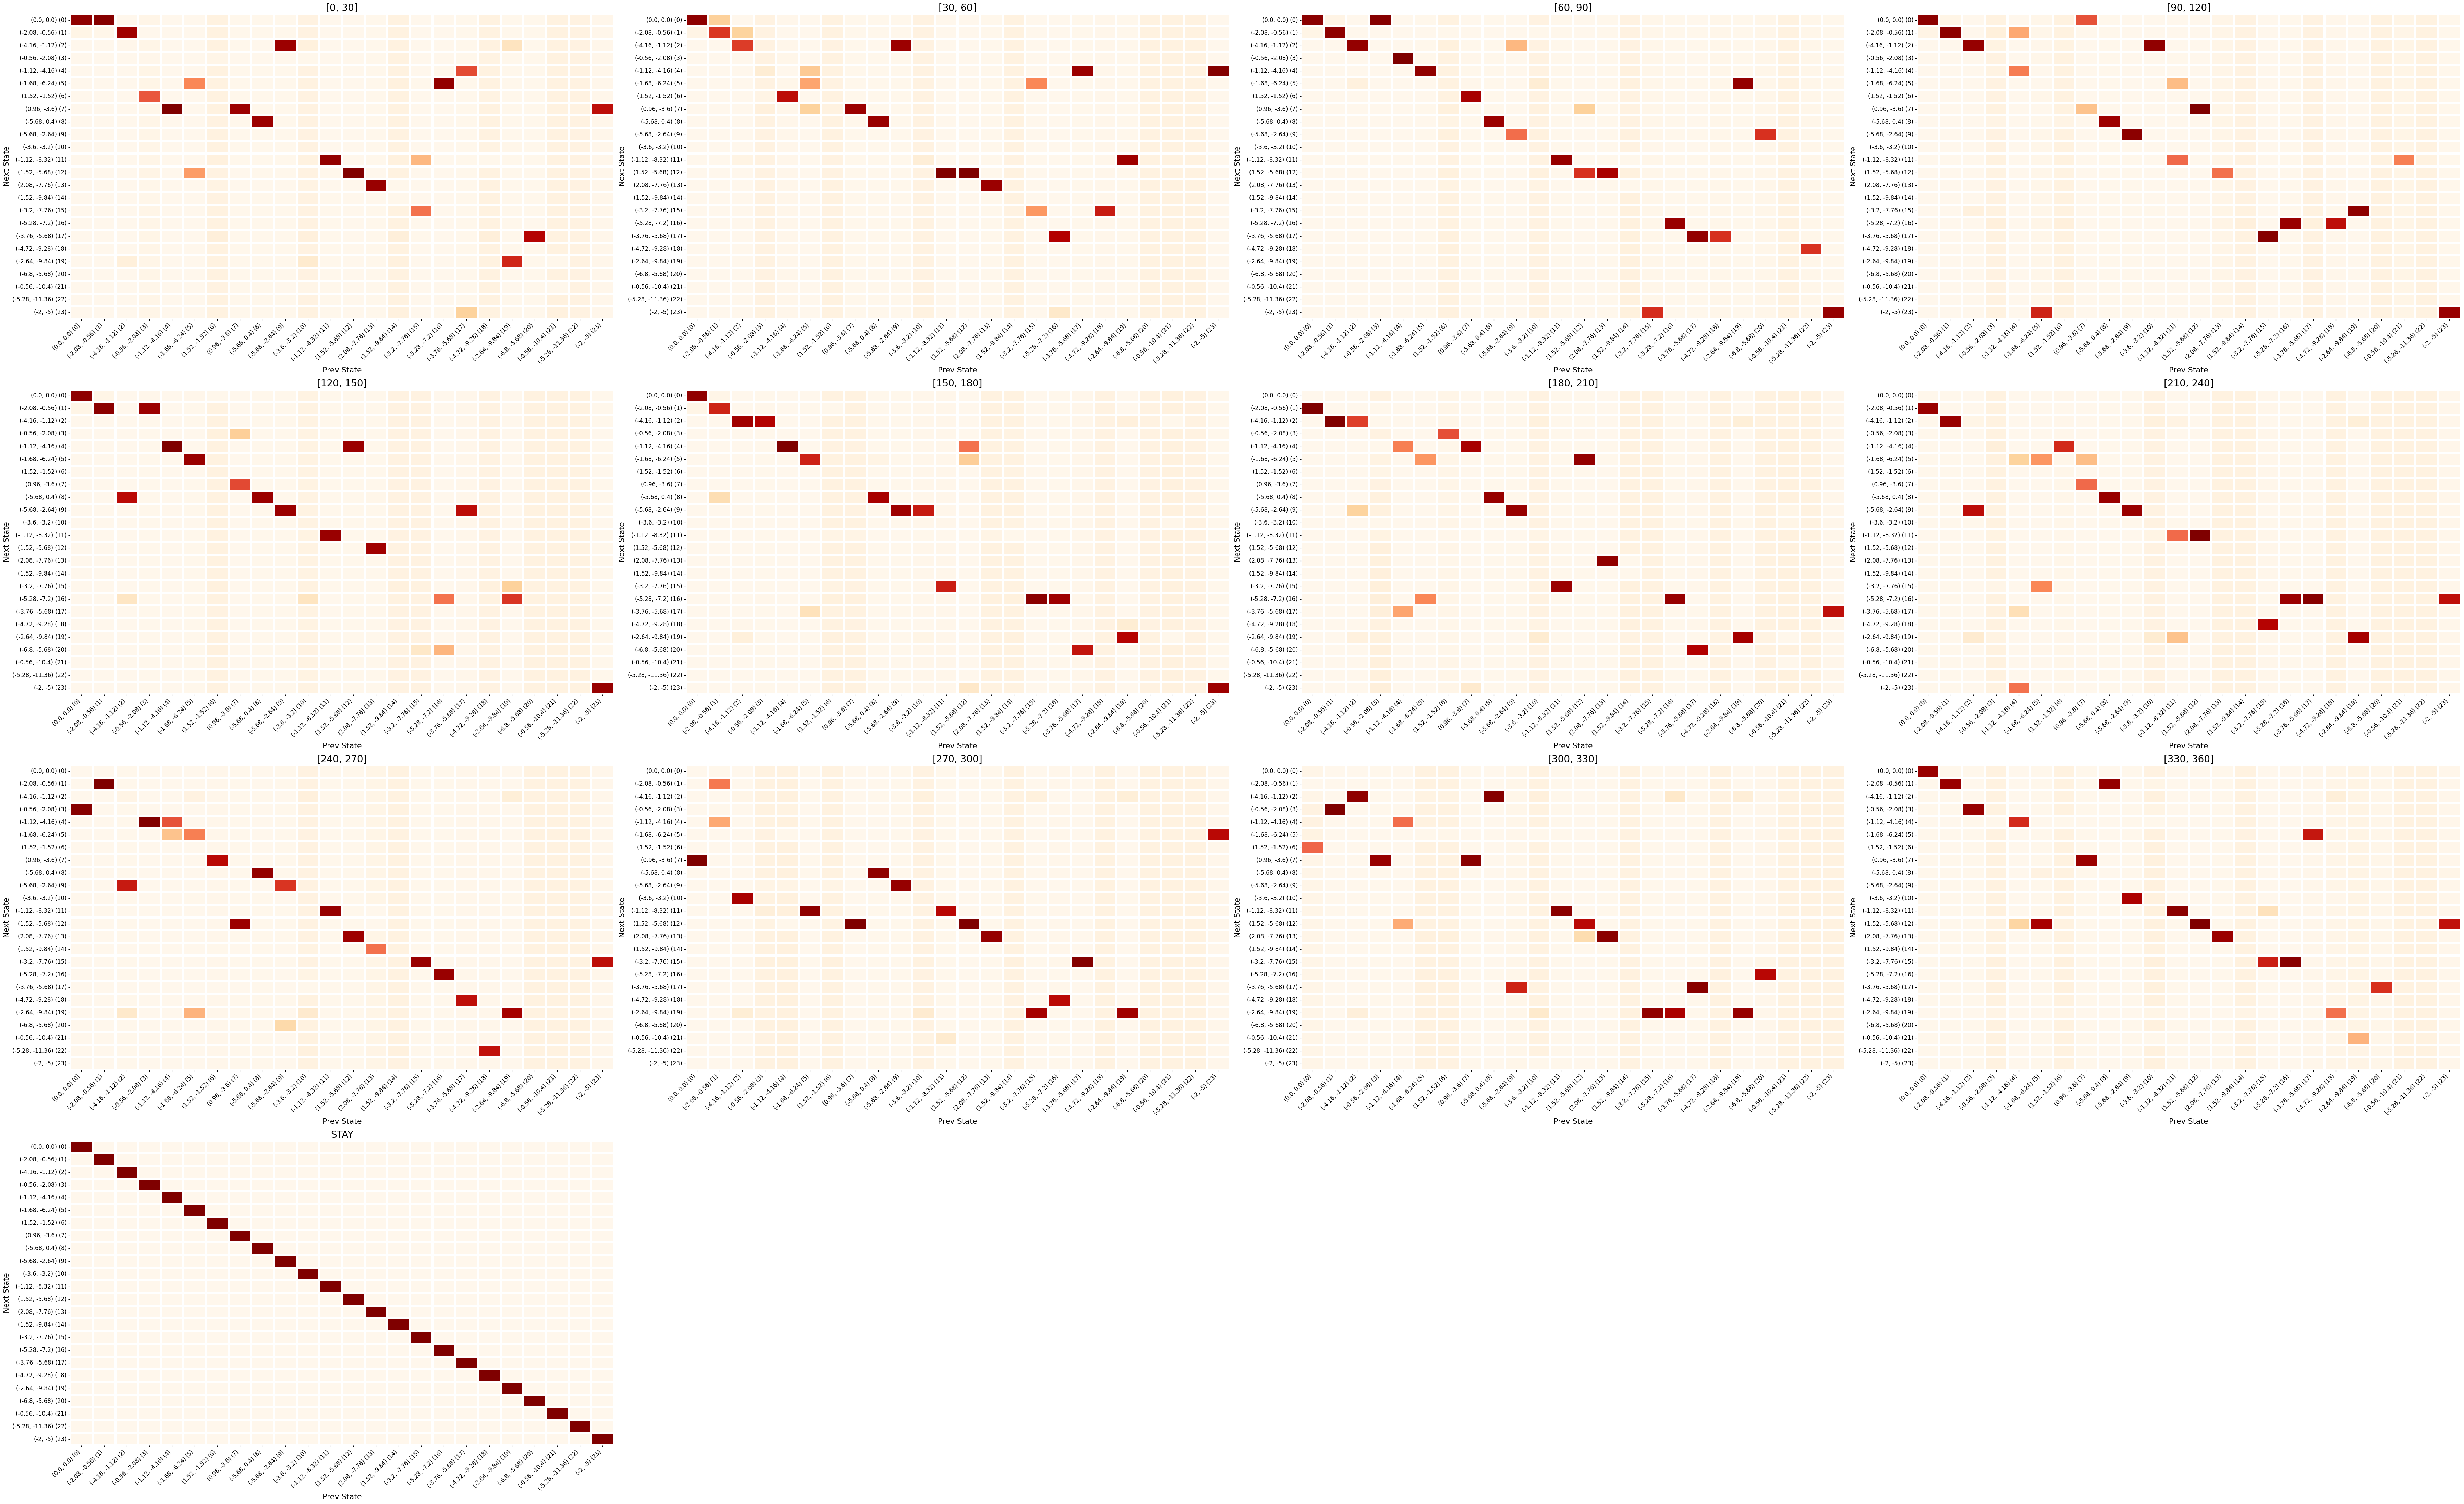

In [176]:
B = plot_transitions(model.get_B(), model.get_agent_state_mapping(), model.possible_actions)